# [Understanding PyTorch with an example: a step-by-step tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)


Daniel Godoy
May 7, 2019


Update (May 18th, 2021): Today I’ve finished my book: Deep Learning with PyTorch Step-by-Step: A Beginner’s Guide.

Update (February 23rd, 2022): The paperback edition is available now (in three volumes). For more details, please check pytorchstepbystep.com.

## Introduction

PyTorch is the fastest growing Deep Learning framework and it is also used by Fast.ai in its MOOC, [Deep Learning for Coders](https://course.fast.ai/) and its [library](https://docs.fast.ai/).

## Motivation

There are many many PyTorch tutorials around and its documentation is quite complete and extensive. So, why should you keep reading this step-by-step tutorial?

Well, even though one can find information on pretty much anything PyTorch can do, I missed having a structured, incremental and from first principles approach to it.

In this post, I will guide you through the main reasons why PyTorch makes it much easier and more intuitive to build a Deep Learning model in Python — autograd, dynamic computation graph, model classes and more — and I will also show you how to avoid some common pitfalls and errors along the way.

Moreover, since this is quite a long post, I built a Table of Contents to make navigation easier, should you use it as a mini-course and work your way through the content one topic at a time.

## Table of Contents

- A Simple Regression Problem
- Gradient Descent
- Linear Regression in Numpy
- PyTorch
- Autograd
- Dynamic Computation Graph
- Optimizer
- Loss
- Model
- Dataset
- DataLoader
- Evaluation

## A Simple Regression Problem

Most tutorials start with some nice and pretty image classification problem to illustrate how to use PyTorch. It may seem cool, but I believe it distracts you from the main goal: how PyTorch works?

For this reason, in this tutorial, I will stick with a simple and familiar problem: a linear regression with a single feature x! It doesn’t get much simpler than that…

![alt text](linreg.png "Title")

## Data Generation

Let’s start generating some synthetic data: we start with a vector of 100 points for our feature x and create our labels using a = 1, b = 2 and some Gaussian noise.

Next, let’s split our synthetic data into train and validation sets, shuffling the array of indices and using the first 80 shuffled points for training.

In [2]:
import numpy as np

# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

![alt text](Fig1.png "Title")

We know that a = 1 and b = 2, but now let’s see how close we can get to the true values by using gradient descent and the 80 points in the training set…

## Gradient Descent

If you are comfortable with the inner workings of gradient descent, feel free to skip this section. It goes beyond the scope of this post to fully explain how gradient descent works, but I’ll cover the four basic steps you’d need to go through to compute it.

### Step 1: Compute the Loss

For a regression problem, the loss is given by the Mean Square Error (MSE), that is, the average of all squared differences between labels (y) and predictions (a + bx).

*It is worth mentioning that, if we use all points in the training set (N) to compute the loss, we are performing a batch gradient descent. If we were to use a single point at each time, it would be a stochastic gradient descent. Anything else (n) in-between 1 and N characterizes a mini-batch gradient descent.*

![alt text](MSE.png "Title")

### Step 2: Compute the Gradients

A gradient is a partial derivative — why partial? Because one computes it with respect to (w.r.t.) a single parameter. We have two parameters, a and b, so we must compute two partial derivatives.

A derivative tells you how much a given quantity changes when you slightly vary some other quantity. In our case, how much does our MSE loss change when we vary each one of our two parameters?

The right-most part of the equations below is what you usually see in implementations of gradient descent for a simple linear regression. In the intermediate step, I show you all elements that pop-up from the application of the chain rule, so you know how the final expression came to be.

![alt text](gradient.png "Title")

### Step 3: Update the Parameters

In the final step, we use the gradients to update the parameters. Since we are trying to minimize our losses, we reverse the sign of the gradient for the update.

There is still another parameter to consider: the learning rate, denoted by the Greek letter eta (that looks like the letter n), which is the multiplicative factor that we need to apply to the gradient for the parameter update.

![alt text](coeffupdate.png "Title")

### Step 4: Rinse and Repeat!

Now we use the updated parameters to go back to Step 1 and restart the process.

An **epoch** is complete whenever every point has been already used for computing the **loss**. For **batch gradient descent**, this is trivial, as it uses all points for computing the loss — one epoch is the same as one update. For **stochastic gradient descent**, one epoch means N updates, while for **mini-batch** (of size n), one epoch has N/n updates.

Repeating this process over and over, for many epochs, is, in a nutshell, training a model.

## Linear Regression in Numpy

It’s time to implement our linear regression model using gradient descent using Numpy only.

*Wait a minute… I thought this tutorial was about PyTorch!*

Yes, it is, but this serves two purposes: first, to introduce the structure of our task, which will remain largely the same and, second, to show you the main pain points so you can fully appreciate how much PyTorch makes your life easier :-)

For training a model, there are two initialization steps:

- Random initialization of parameters/weights (we have only two, a and b) — lines 3 and 4;
- Initialization of hyper-parameters (in our case, only learning rate and number of epochs) — lines 9 and 11;

Make sure to always initialize your random seed to ensure **reproducibility** of your results. As usual, the random seed is 42, the least random of all random seeds one could possibly choose :-)

For each **epoch**, there are four **training steps**:

- Compute model’s predictions — this is the forward pass — line 15;
- Compute the loss, using predictions and and labels and the appropriate loss function for the task at hand — lines 18 and 20;
- Compute the gradients for every parameter — lines 23 and 24;
- Update the parameters — lines 27 and 28;

Just keep in mind that, if you don’t use batch gradient descent (our example does),you’ll have to write an inner loop to perform the four training steps for either each individual point (stochastic) or n points (mini-batch). We’ll see a mini-batch example later down the line.

In [5]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train

    # How wrong is our model? That's the error!
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()

    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


Just to make sure we haven’t done any mistakes in our code, we can use Scikit-Learn’s Linear Regression to fit the model and compare the coefficients.

In [ ]:
# a and b after initialization
[0.49671415] [-0.1382643]
# a and b after our gradient descent
[1.02354094] [1.96896411]
# intercept and coef from Scikit-Learn
[1.02354075] [1.96896447]

They match up to 6 decimal places — we have a fully working implementation of linear regression using Numpy.

Time to TORCH it :-)

## PyTorch
First, we need to cover a few basic concepts that may throw you off-balance if you don’t grasp them well enough before going full-force on modeling.

In **Deep Learning**, we see **tensors** everywhere. Well, Google’s framework is called **TensorFlow** for a reason! What is a tensor, anyway?


## Tensor

In *Numpy*, you may have an **array** that has **three dimensions**, right? That is, technically speaking, a **tensor**.

A **scalar** (a single number) has **zero** dimensions, a **vector** has one dimension, a **matrix** has two dimensions and a **tensor** has three or more dimensions. That’s it!

But, to keep things simple, it is commonplace to call vectors and matrices tensors as well — so, from now on, **everything is either a scalar or a tensor**.

![alt text](tensors.png "Title")

## Loading Data, Devices and CUDA

*”How do we go from Numpy’s arrays to PyTorch’s tensors”*, you ask? That’s what **from_numpy** is good for. It returns a **CPU tensor**, though.

*“But I want to use my fancy GPU…”*, you say. No worries, that’s what **to()** is good for. It sends your tensor to whatever **device** you specify, including your **GPU** (referred to as **cuda** or **cuda:0**).

*“What if I want my code to fallback to CPU if no GPU is available?”*, you may be wondering… PyTorch got your back once more — you can use **cuda.is_available()** to find out if you have a GPU at your disposal and set your device accordingly.

You can also easily **cast** it to a lower precision (32-bit float) using **float()**.

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


If you compare the types of both variables, you’ll get what you’d expect: numpy.ndarray for the first one and torch.Tensor for the second one.

But where does your nice tensor “live”? In your CPU or your GPU? You can’t say… but if you use PyTorch’s type(), it will reveal its location — torch.cuda.FloatTensor — a GPU tensor in this case.

We can also go the other way around, turning tensors back into Numpy arrays, using numpy(). It should be easy as x_train_tensor.numpy() but…

```
TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
```

Unfortunately, Numpy cannot handle GPU tensors… you need to make them CPU tensors first using cpu().

## Creating Parameters

What distinguishes a *tensor* used for *data* — like the ones we’ve just created — from a **tensor** used as a (trainable) **parameter/weight**?

The latter tensors require the **computation of its gradients**, so we can **update** their values (the parameters’ values, that is). That’s what the **requires_grad=True** argument is good for. It tells PyTorch we want it to compute gradients for us.

You may be tempted to create a simple tensor for a parameter and, later on, send it to your chosen device, as we did with our data, right? Not so fast…

In [11]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([2.3260], requires_grad=True) tensor([-0.8465], requires_grad=True)
tensor([0.2894], requires_grad=True) tensor([-1.0516], requires_grad=True)
tensor([1.4221], requires_grad=True) tensor([-1.2239], requires_grad=True)


![alt text](copiedText.png "Title")

Although the last approach worked fine, it is much better to **assign** tensors to a **device** at the moment of their **creation**.

In [12]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


``tensor([0.6226], device='cuda:0', requires_grad=True) tensor([1.4505], device='cuda:0', requires_grad=True)``

Much easier, right?

Now that we know how to create tensors that require gradients, let’s see how PyTorch handles them — that’s the role of the…

## Autograd

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule or anything like it.

So, how do we tell PyTorch to do its thing and compute all gradients? That’s what backward() is good for.

Do you remember the starting point for computing the gradients? It was the loss, as we computed its partial derivatives w.r.t. our parameters. Hence, we need to invoke the backward() method from the corresponding Python variable, like, loss.backward().

What about the actual values of the gradients? We can inspect them by looking at the grad attribute of a tensor.

If you check the method’s documentation, it clearly states that gradients are accumulated. So, every time we use the gradients to update the parameters, we need to zero the gradients afterwards. And that’s what zero_() is good for.

What does the underscore (_) at the end of the method name mean? Do you remember? If not, scroll back to the previous section and find out.

So, let’s ditch the manual computation of gradients and use both backward() and zero_() methods instead.

That’s it? Well, pretty much… but, there is always a catch, and this time it has to do with the update of the parameters…

In [19]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients!
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()

    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    # print(a.grad)
    # print(b.grad)

    # What about UPDATING the parameters? Not so fast...

    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad

    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()

print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In the first attempt, if we use the same update structure as in our Numpy code, we’ll get the weird error below… but we can get a hint of what’s going on by looking at the tensor itself — once again we “lost” the gradient while reassigning the update results to our parameters. Thus, the grad attribute turns out to be None and it raises the error…

```
FIRST ATTEMPT
tensor([0.7518], device='cuda:0', grad_fn=<SubBackward0>)
AttributeError: 'NoneType' object has no attribute 'zero_'
```

We then change it slightly, using a familiar in-place Python assignment in our second attempt. And, once again, PyTorch complains about it and raises an error.

```

# SECOND ATTEMPT
RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
```

Why?! It turns out to be a case of “too much of a good thing”. The culprit is PyTorch’s ability to build a dynamic computation graph from every Python operation that involves any gradient-computing tensor or its dependencies.

We’ll go deeper into the inner workings of the dynamic computation graph in the next section.

So, how do we tell PyTorch to “back off” and let us update our parameters without messing up with its fancy dynamic computation graph? That’s what torch.no_grad() is good for. It allows us to perform regular Python operations on tensors, independent of PyTorch’s computation graph.

Finally, we managed to successfully run our model and get the resulting parameters. Surely enough, they match the ones we got in our Numpy-only implementation.

```
# THIRD ATTEMPT
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)
```

## Dynamic Computation Graph

*“Unfortunately, no one can be told what the dynamic computation graph is. You have to see it for yourself.”* Morpheus


How great was “The Matrix”? Right, right? But, jokes aside, I want you to see the graph for yourself too!

The **PyTorchViz** package with the bare minimum: two (gradient computing) tensors for our parameters, predictions, errors and loss.

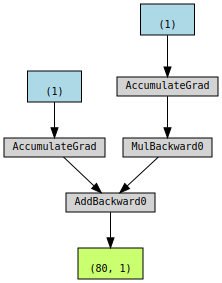

In [24]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

make_dot(yhat)

Calling make_dot(yhat) produces the left-most graph on Figure 3 below:

![alt text](Figure3.png "Title")

Let’s take a closer look at its components:

- blue boxes: these correspond to the tensors we use as parameters, the ones we’re asking PyTorch to compute gradients for;
- gray box: a Python operation that involves a gradient-computing tensor or its dependencies;
- green box: the same as the gray box, except it is the starting point for the computation of gradients (assuming the backward()method is called from the variable used to visualize the graph)— they are computed from the bottom-up in a graph.

If we plot graphs for the error (center) and loss (right) variables, the only difference between them and the first one is the number of intermediate steps (gray boxes).

Now, take a closer look at the green box of the left-most graph: there are two arrows pointing to it, since it is adding up two variables, a and b*x. Seems obvious, right?

Then, look at the gray box of the same graph: it is performing a multiplication, namely, b*x. But there is only one arrow pointing to it! The arrow comes from the blue box that corresponds to our parameter b.

Why don’t we have a box for our data x? The answer is: we do not compute gradients for it! So, even though there are more tensors involved in the operations performed by the computation graph, it only shows gradient-computing tensors and its dependencies.

What would happen to the computation graph if we set requires_grad to False for our parameter a?

![alt text](Fig4.png "Title")

Unsurprisingly, the blue box corresponding to the parameter a is no more! Simple enough: no gradients, no graph.

The best thing about the dynamic computing graph is the fact that you can make it as complex as you want it. You can even use control flow statements (e.g., if statements) to control the flow of the gradients (obviously!) :-)

Figure 5 below shows an example of this. And yes, I do know that the computation itself is completely nonsense…

![alt text](Fig5.png "Title")






## Optimizer

So far, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers, like [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) or [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its step() method.

Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s zero_grad() method and that’s it!

In the code below, we create a Stochastic Gradient Descent (SGD) optimizer to update our parameters a and b.

*Don’t be fooled by the optimizer’s name: if we use all training data at once for the update — as we are actually doing in the code — the optimizer is performing a batch gradient descent, despite of its name.*

In [25]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()

    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()

    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()

print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


Cool! We’ve optimized the optimization process :-) What’s left?

## Loss

We now tackle the loss computation. As expected, PyTorch got us covered once again. There are many loss functions to choose from, depending on the task at hand. Since ours is a regression, we are using the Mean Square Error (MSE) loss.

Notice that nn.MSELoss actually creates a loss function for us — it is NOT the loss function itself. Moreover, you can specify a reduction method to be applied, that is, how do you want to aggregate the results for individual points — you can average them (reduction=’mean’) or simply sum them up (reduction=’sum’).

We then use the created loss function later, at line 20, to compute the loss given our predictions and our labels.

Our code looks like this now:

In [26]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor

    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


At this point, there’s only one piece of code left to change: the predictions. It is then time to introduce PyTorch’s way of implementing a…

## Model

In PyTorch, a model is represented by a regular Python class that inherits from the Module class.

The most fundamental methods it needs to implement are:

- **__init__(self)**: it defines the parts that make up the model —in our case, two parameters, a and b.

You are not limited to defining parameters, though… models can contain other models (or layers) as its attributes as well, so you can easily nest them. We’ll see an example of this shortly as well.

- **forward(self, x)**: it performs the actual computation, that is, it outputs a prediction, given the input x.

*You should NOT call the forward(x) method, though. You should call the whole model itself, as in model(x) to perform a forward pass and output predictions.*

Let’s build a proper (yet simple) model for our regression task. It should look like this:

In [27]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In the __init__ method, we define our two parameters, a and b, using the Parameter() class, to tell PyTorch these tensors should be considered parameters of the model they are an attribute of.

Why should we care about that? By doing so, we can use our model’s parameters() method to retrieve an iterator over all model’s parameters, even those parameters of nested models, that we can use to feed our optimizer (instead of building a list of parameters ourselves!).

Moreover, we can get the current values for all parameters using our model’s state_dict() method.

*IMPORTANT: we need to send our model to the same device where the data is. If our data is made of GPU tensors, our model must “live” inside the GPU as well.*

We can use all these handy methods to change our code, which should be looking like this:

In [28]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)

    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


Now, the printed statements will look like this — final values for parameters a and b are still the same, so everything is ok :-)

```
OrderedDict([('a', tensor([0.3367], device='cuda:0')), ('b', tensor([0.1288], device='cuda:0'))])
OrderedDict([('a', tensor([1.0235], device='cuda:0')), ('b', tensor([1.9690], device='cuda:0'))])
```


I hope you noticed one particular statement in the code, to which I assigned a comment “What is this?!?” — model.train().

*In PyTorch, models have a train() method which, somewhat disappointingly, does NOT perform a training step. Its only purpose is to set the model to training mode. Why is this important? Some models may use mechanisms like Dropout, for instance, which have distinct behaviors in training and evaluation phases.*

## Nested Models

In our model, we manually created two parameters to perform a linear regression. Let’s use PyTorch’s Linear model as an attribute of our own, thus creating a nested model.

Even though this clearly is a contrived example, as we are pretty much wrapping the underlying model without adding anything useful (or, at all!) to it, it illustrates well the concept.

In the __init__ method, we created an attribute that contains our nested Linear model.

In the forward() method, we call the nested model itself to perform the forward pass (notice, we are not calling self.linear.forward(x)!).

In [29]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

Now, if we call the parameters() method of this model, PyTorch will figure the parameters of its attributes in a recursive way. You can try it yourself using something like: [*LayerLinearRegression().parameters()] to get a list of all parameters. You can also add new Linear attributes and, even if you don’t use them at all in the forward pass, they will still be listed under parameters().

In [30]:
[*LayerLinearRegression().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True),
 Parameter containing:
 tensor([0.2018], requires_grad=True)]

## Sequential Models

Our model was simple enough… You may be thinking: “why even bother to build a class for it?!” Well, you have a point…

For straightforward models, that use run-of-the-mill layers, where the output of a layer is sequentially fed as an input to the next, we can use a, er… Sequential model :-)

In our case, we would build a Sequential model with a single argument, that is, the Linear layer we used to train our linear regression. The model would look like this:

```
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)
```


## Training Step

So far, we’ve defined an optimizer, a loss function and a model. Scroll up a bit and take a quick look at the code inside the loop. Would it change if we were using a different optimizer, or loss, or even model? If not, how can we make it more generic?

Well, I guess we could say all these lines of code perform a training step, given those three elements (optimizer, loss and model),the features and the labels.

So, how about writing a function that takes those three elements and returns another function that performs a training step, taking a set of features and labels as arguments and returning the corresponding loss?

Then we can use this general-purpose function to build a train_step() function to be called inside our training loop. Now our code should look like this… see how tiny the training loop is now?

In [31]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)

# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


Let’s give our training loop a rest and focus on our data for a while… so far, we’ve simply used our Numpy arrays turned PyTorch tensors. But we can do better, we can build a…

## Dataset

In PyTorch, a dataset is represented by a regular Python class that inherits from the Dataset class. You can think of it as a kind of a Python list of tuples, each tuple corresponding to one point (features, label).

The most fundamental methods it needs to implement are:

- __init__(self) : it takes whatever arguments needed to build a list of tuples — it may be the name of a CSV file that will be loaded and processed; it may be two tensors, one for features, another one for labels; or anything else, depending on the task at hand.

*There is no need to load the whole dataset in the constructor method (__init__). If your dataset is big (tens of thousands of image files, for instance), loading it at once would not be memory efficient. It is recommended to load them on demand (whenever __get_item__ is called).*

- __get_item__(self, index): it allows the dataset to be indexed, so it can work like a list (dataset[i]) — it must return a tuple (features, label) corresponding to the requested data point. We can either return the corresponding slices of our pre-loaded dataset or tensors or, as mentioned above, load them on demand (like in [this example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)).
- __len__(self): it should simply return the size of the whole dataset so, whenever it is sampled, its indexing is limited to the actual size.

Let’s build a simple custom dataset that takes two tensors as arguments: one for the features, one for the labels. For any given index, our dataset class will return the corresponding slice of each of those tensors. It should look like this:

In [32]:
# Creating datasets using train tensors

from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


Once again, you may be thinking “why go through all this trouble to wrap a couple of tensors in a class?”. And, once again, you do have a point… if a dataset is nothing else but a couple of tensors, we can use PyTorch’s TensorDataset class, which will do pretty much what we did in our custom dataset above.

Did you notice we built our training tensors out of Numpy arrays but we did not send them to a device? So, they are CPU tensors now! Why?

We don’t want our whole training data to be loaded into GPU tensors, as we have been doing in our example so far, because it takes up space in our precious graphics card’s RAM.

OK, fine, but then again, why are we building a dataset anyway? We’re doing it because we want to use a…

## DataLoader

Until now, we have used the whole training data at every training step. It has been batch gradient descent all along. This is fine for our ridiculously small dataset, sure, but if we want to go serious about all this, we must use mini-batch gradient descent. Thus, we need mini-batches. Thus, we need to slice our dataset accordingly. Do you want to do it manually?! Me neither!

So we use PyTorch’s DataLoader class for this job. We tell it which dataset to use (the one we just built in the previous section), the desired mini-batch size and if we’d like to shuffle it or not. That’s it!

Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time.

In [33]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

To retrieve a sample mini-batch, one can simply run the command below — it will return a list containing two tensors, one for the features, another one for the labels.

In [34]:
next(iter(train_loader))

[tensor([[0.7852],
         [0.8022],
         [0.6075],
         [0.1997],
         [0.3309],
         [0.6376],
         [0.4722],
         [0.2809],
         [0.4938],
         [0.5427],
         [0.1560],
         [0.1987],
         [0.3745],
         [0.0885],
         [0.7320],
         [0.8872]]),
 tensor([[2.5283],
         [2.6229],
         [2.4037],
         [1.3651],
         [1.5427],
         [2.1930],
         [1.9857],
         [1.5846],
         [1.9060],
         [2.2161],
         [1.2901],
         [1.2654],
         [1.7578],
         [1.0708],
         [2.4732],
         [2.8708]])]

How does this change our training loop? Let’s check it out!

In [35]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)

print(model.state_dict())

OrderedDict([('a', tensor([1.0202])), ('b', tensor([1.9676]))])


Two things are different now: not only we have an inner loop to load each and every mini-batch from our DataLoader but, more importantly, we are now sending only one mini-batch to the device.

For bigger datasets, loading data sample by sample (into a CPU tensor) using Dataset’s __get_item__ and then sending all samples that belong to the same mini-batch at once to your GPU (device) is the way to go in order to make the best use of your graphics card’s RAM.

Moreover, if you have many GPUs to train your model on, it is best to keep your dataset “agnostic” and assign the batches to different GPUs during training.

So far, we’ve focused on the training data only. We built a dataset and a data loader for it. We could do the same for the validation data, using the split we performed at the beginning of this post… or we could use random_split instead.

## Random Split

PyTorch’s random_split() method is an easy and familiar way of performing a training-validation split. Just keep in mind that, in our example, we need to apply it to the whole dataset (not the training dataset we built in two sections ago).

Then, for each subset of data, we build a corresponding DataLoader, so our code looks like this:

In [36]:
# Splitting the dataset into training and validation sets, the PyTorch way!

from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

Now we have a data loader for our validation set, so, it makes sense to use it for the…

## Evaluation

This is the last part of our journey — we need to change the training loop to include the evaluation of our model, that is, computing the validation loss. The first step is to include another inner loop to handle the mini-batches that come from the validation loader , sending them to the same device as our model. Next, we make predictions using our model (line 23) and compute the corresponding loss (line 24).

That’s pretty much it, but there are two small, yet important, things to consider:

- torch.no_grad(): even though it won’t make a difference in our simple model, it is a good practice to wrap the validation inner loop with this context manager to disable any gradient calculation that you may inadvertently trigger — gradients belong in training, not in validation steps;
- eval(): the only thing it does is setting the model to evaluation mode (just like its train() counterpart did), so the model can adjust its behavior regarding some operations, like Dropout.

Now, our training loop should look like this:

In [37]:
# Computing validation loss

losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('a', tensor([1.0199])), ('b', tensor([1.9728]))])
